<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/15_PatchTST_a_new_transformer_for_LTSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: oguiza@timeseriesAI.co

# Purpose 😇

In this notebook, we are going to learn how to use a new state-of-the-art time series transformer called **PatchTST** to create a long-term multivariate time series forecast (LTSF). PatchTST was introduced in the following paper:

* paper: Nie, Y., Nguyen, N. H., Sinthong, P., & Kalagnanam, J. (2022). **A Time Series is Worth 64 Words: Long-term Forecasting with Transformers**. arXiv preprint arXiv:2211.14730.
* arxiv link: https://arxiv.org/abs/2211.14730
* official repository: https://github.com/yuqinie98/PatchTST

The paper will be presented at the **ICLR 2023** Conference later this year. Here's the summary of the paper review by ICLR reviewers:

"The paper applies transformer to long term forecasting problems of multi-dimensional time series. The method is very simple: Take channels independently, break them into patches and predict the patches into the future using the transformer. The main advantage of this paper is that previous papers have applied transformers to this problem but it resulted in a very weak performance, being beaten by a simple linear methods. This paper found a way to apply the transformer successfully, beating the previous methods."

I'd like to thank the authors for publishing this paper, and for making their code available.

Below you can see the results of publised in the paper.

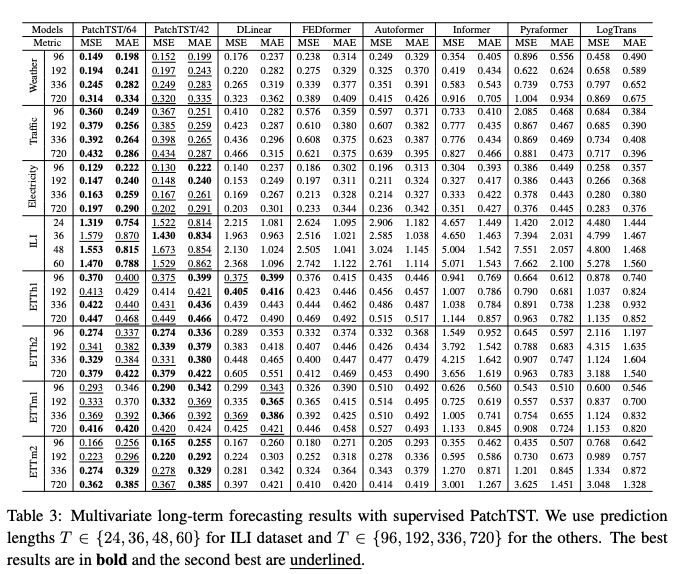

# Install & import libraries 📚

You'll need tsai >= 0.3.5 to be able to run this tutorial.

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/timeseriesAI/tsai.git /tmp/pip-req-build-ex6o8mf1


In [1]:
import sklearn
from tsai.basics import *
my_setup(sklearn)

os              : Windows-10-10.0.22631-SP0
python          : 3.10.16
tsai            : 0.4.1
fastai          : 2.7.18
fastcore        : 1.7.29
sklearn         : 1.6.1
torch           : 2.5.1+cpu
device          : cpu
cpu cores       : 20
threads per cpu : 1
RAM             : 15.78 GB
GPU memory      : [8.0] GB


# Load and prepare data 🔢

The starting point for this tutorial will be a dataframe that contains our long-term time series data. 

`tsai` allows you to easily download and prepare data from 9 popular datasets, including weather, traffic, electricity, exchange rate, ILI, and four ETT datasets (ETTh1, ETTh2, ETTm1, ETTm2). These datasets have been extensively utilized for long-term time series forecasting benchmarking.

You can download all data from here: https://cloud.tsinghua.edu.cn/d/e1ccfff39ad541908bae/

Here are the statistics of these datasets:

| Datasets | Weather | Traffic | Electricity | Exchange | ILI | ETTh1 | ETTh2 | ETTm1 | ETTm2 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Features | 21 | 862 | 321 | 8 | 7 | 7 | 7 | 7 | 7 |
| Timesteps | 52696 | 17544 | 26304 | 7588 | 966 | 17420 | 17420 | 69680 | 69680 |


## Data preparation steps

There are 5 steps required to prepare data for a forecasting task in `tsai`:

1. Prepare a dataframe with your data, including the variable you want to predict. 
2. Preprocess your data.
3. Define train, valid and test splits.
4. Scale your data using the train split. 
5. Apply a sliding window to prepare your input and output data.

### Prepare dataframe

In this case, we are going to download the dataframe using get_long_term_forecasting_data. You can use any of the following datasets: "ETTh1", "ETTh2", "ETTm1", "ETTm2", "electricity", "exchange_rate", "traffic", "weather", or "ILI".

We are going to use a small dataset called ILI. ILI includes the weekly recorded **influenza-like illness (ILI)** patients data from Centers for
Disease Control and Prevention of the United States between 2002 and 2021, which describes the ratio of patients seen with ILI and the total number of the patients.

The task is a multivariate long-term time series forecasting (LTSF), where multiple variables are predicted simultaneously for multiple time steps.

In [4]:
dsid = "ETTh1"
df_raw = get_long_term_forecasting_data(dsid, target_dir="D:/Python_Project/toolscript", task='S')
df_raw

,date,down_outside_fuse
0,2025-03-17 15:22:24,65.4634
1,2025-03-17 15:23:24,37.9414
2,2025-03-17 15:24:24,29.5204
3,2025-03-17 15:25:24,46.3698
4,2025-03-17 15:26:24,34.0886
...,...,...
9995,2025-03-24 13:57:24,38.0797
9996,2025-03-24 13:58:24,35.1414
9997,2025-03-24 13:59:24,83.2303
9998,2025-03-24 14:00:24,83.3873


### Proprocess dataframe

`tsai` provides some sklearn-style transforms that can be used to build a preprocessing pipeline. In this case we'll use the following transforms: 

* TSShrinkDataFrame: to save some memory and set the right dtypes.
* TSDropDuplicates: to ensure there are no duplicate timestamps.
* TSAddMissingTimestamps: to fill any missing timestamps. 
* TSFillMissing: to fill any missing data (forward fill, then 0).

All these transforms can be applied to the entire dataset. In other words, they are not dependent on the training set. Other transforms will be applied later, when the training split is available.

You can read about all available transforms in the [docs](https://timeseriesai.github.io/tsai/data.preprocessing.html#sklearn-api-transforms).

In [ ]:
datetime_col = "date"
freq = 'm'
columns = df_raw.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df_raw)
df

data directory already exists.
Pipeline saved as data\preproc_pipe.pkl
Initial memory usage: 156.38 KB 
Final memory usage  : 117.31 KB  (-25.0%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


,date,down_outside_fuse
0,2025-03-17 15:22:24,65.463402
1,2025-03-17 16:22:24,64.720703
2,2025-03-17 17:22:24,63.022598
3,2025-03-17 18:22:24,41.804401
4,2025-03-17 19:22:24,1.312580
...,...,...
162,2025-03-24 09:22:24,98.128403
163,2025-03-24 10:22:24,0.735455
164,2025-03-24 11:22:24,69.043297
165,2025-03-24 12:22:24,36.062302


### Define splits

So we have transformed a multivariate time series with 966 time steps and 7 features (excluding the datetime) into:

* 803 input samples, with 7 features and 104 historical time steps
* 803 input samples, with 7 features and 60 future time steps.

It's very easy to create time forecasting splits in `tsai`. You can use as function called `get_forecasting_splits`:

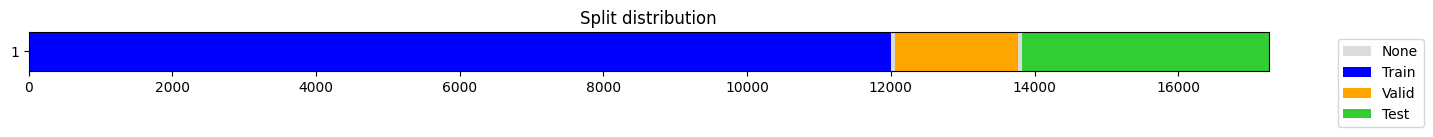

((#11997) [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19...],
 (#1714) [12056,12057,12058,12059,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075...],
 (#3428) [13829,13830,13831,13832,13833,13834,13835,13836,13837,13838,13839,13840,13841,13842,13843,13844,13845,13846,13847,13848...])

In [8]:
fcst_history = 104 # # steps in the past
fcst_horizon = 60  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits

However, in this example, we are going to apply the same splits they used in the original paper. You can use `get_forecasting splits` to use them. 

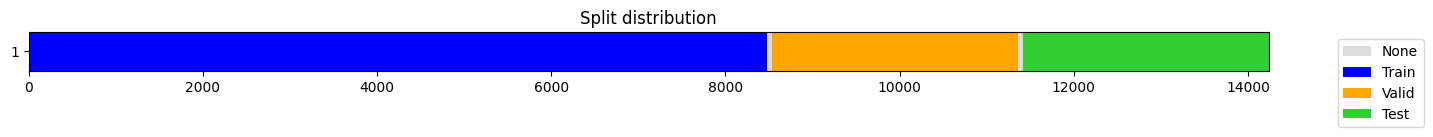

((#8477) [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19...],
 (#2821) [8536,8537,8538,8539,8540,8541,8542,8543,8544,8545,8546,8547,8548,8549,8550,8551,8552,8553,8554,8555...],
 (#2821) [11416,11417,11418,11419,11420,11421,11422,11423,11424,11425,11426,11427,11428,11429,11430,11431,11432,11433,11434,11435...])

In [9]:
splits = get_long_term_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, dsid=dsid)
splits

### Scale dataframe

Now that we have defined the splits for this particular experiment, we'll scale the data: 

In [10]:
columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data\exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,date,HUFL
0,2016-07-01 00:00:00,-0.372205
1,2016-07-01 01:00:00,-0.395287
2,2016-07-01 02:00:00,-0.487614
3,2016-07-01 03:00:00,-0.499155
4,2016-07-01 04:00:00,-0.452991
...,...,...
17415,2018-06-26 15:00:00,-1.664269
17416,2018-06-26 16:00:00,-2.321929
17417,2018-06-26 17:00:00,-0.891373
17418,2018-06-26 18:00:00,0.216209


### Apply a sliding window

We'll approach the time series forecasting task as a supervised learning problem. Remember that `tsai` requires that both inputs and outputs have the following shape: 

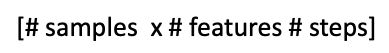

To get those inputs and outputs we're going to use a function called `prepare_forecasting_data` that applies a sliding window along the dataframe:

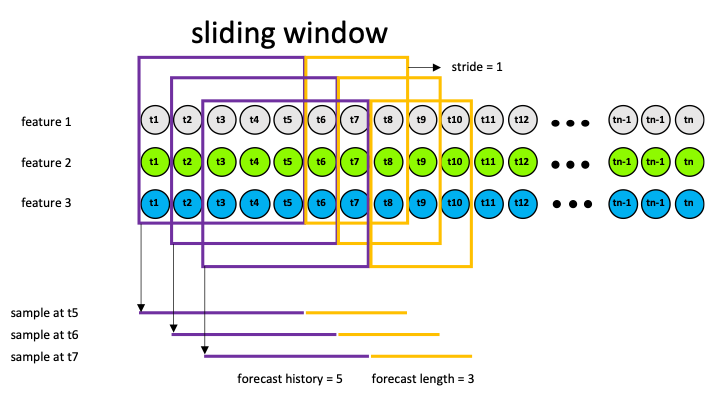

To use `prepare_forecasting_data` we need to define some settings: 

In [11]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [12]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((17257, 1, 104), (17257, 1, 60))

# Prepare the forecaster 🏋️‍♂️

Now we'll instantiate the forecaster. In `tsai` there's a class called TSForecaster. We are going to use the same settings they used in the paper. 

You can find ILI specific settings here: https://github.com/yuqinie98/PatchTST/blob/main/PatchTST_supervised/scripts/PatchTST/illness.sh

and default model settings here: https://github.com/yuqinie98/PatchTST/blob/main/PatchTST_supervised/run_longExp.py

In [13]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

In [14]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

☢️ This is **not good practice**, but all papers using these long-term forecasting datasets have published there data using drop_last=True in the validtion set. You should never use it in your practice. But if you want to try and replicate the results from the paper, you may want to uncomment the following line and set `learn.dls.valid.drop_last=True`. 

In [ ]:
# learn.dls.valid.drop_last = True

In [15]:
learn.summary()

not enough values to plot a chart


PatchTST (Input shape: 16 x 1 x 104)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 1 x 60         
RevIN                                     2          True      
____________________________________________________________________________
                     16 x 1 x 106        
ReplicationPad1d                                               
____________________________________________________________________________
                     16 x 24 x 42        
Unfold                                                         
____________________________________________________________________________
                     16 x 1 x 42 x 16    
Linear                                    400        True      
Dropout                                                        
Linear                                    272        True      
Linear                                    272        True      
Linear                                    272       

As you can see this is a very small model, with only 57k parameters!

# Train model 🏃🏿‍♂️

In this case we'll use the same number of epochs and learning rate they used in the paper. 

⚠️ Whenever you need to look for a good learning rate to train a model you can use:
```python
lr_max = learn.lr_find().valley
```

epoch,train_loss,valid_loss,mse,mae,time
0,0.351617,0.682766,0.682766,0.602993,00:09
1,0.315250,0.613190,0.613190,0.568648,00:09


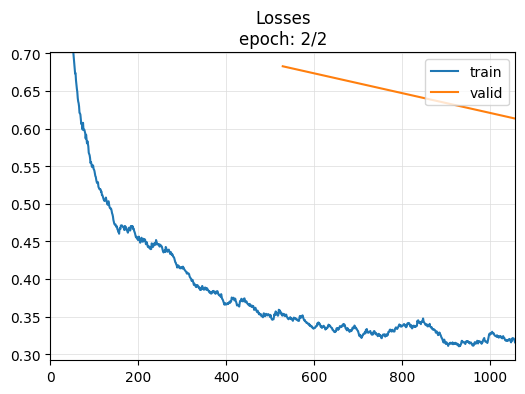

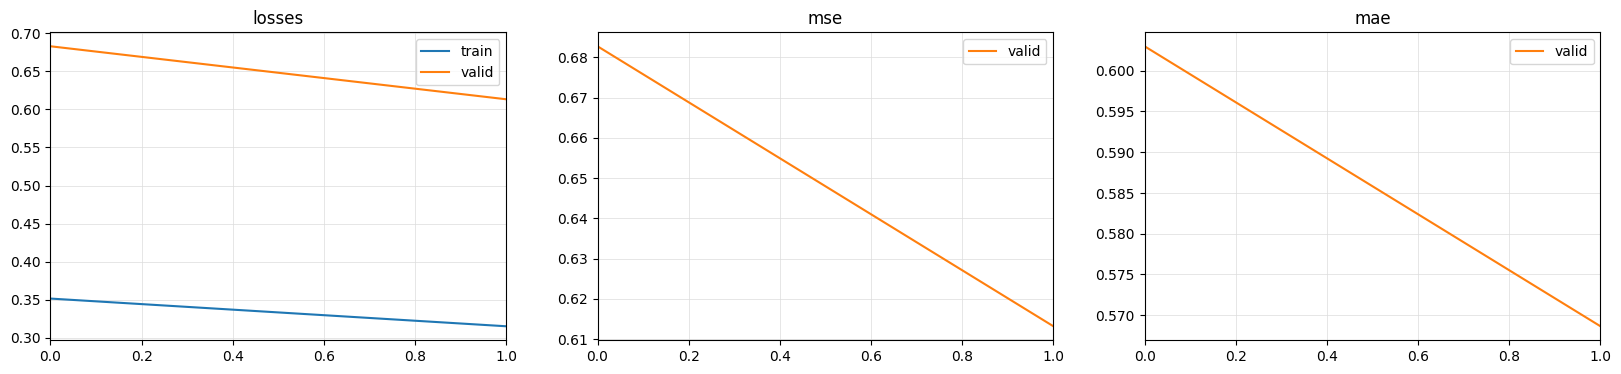

In [17]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 2
lr_max = 0.0025
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

# Evaluate model 🕵️‍♀️

## Valid split

First we are going to check that the valid predictions match the results we got during training. But you can skip this step since it's not required.

In [ ]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df

scaled_preds.shape: (38, 7, 60)


,mse,mae
valid,0.345804,0.374178


## Test split

So now we'll use the test split to measure performance (this is the one you that is published in the paper). 

⚠️ You may find some differences due to randomness of the process. In addition to that, the authors used a test dataloader that drop the last batch if incomplete, which means that not all samples are used to measure performance. In `tsai` we are using all samples.

In [ ]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (134, 7, 60)


,mse,mae
test,1.534231,0.799998


### Visualize predictions

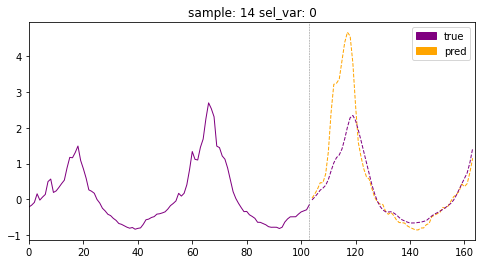

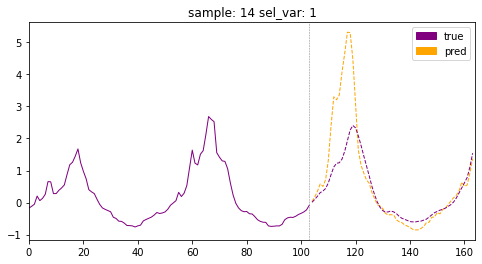

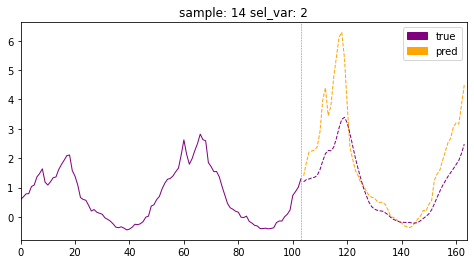

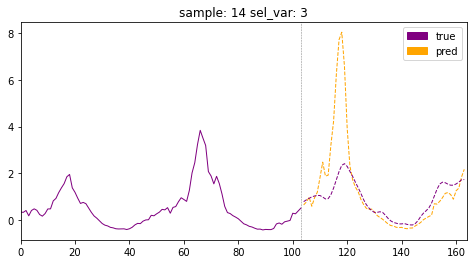

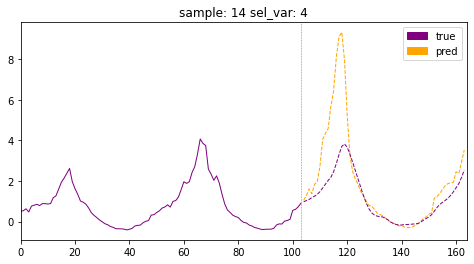

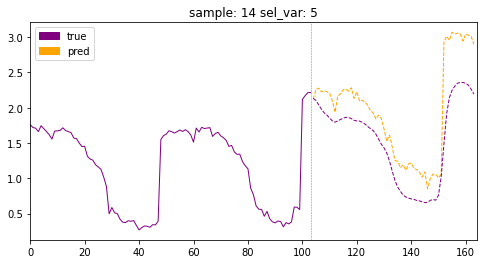

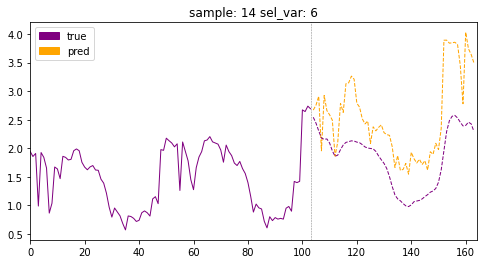

In [ ]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

# Inference 🚀 

## Prepare dataframe

If you want to use the model with new data, you'll need to first prepare the data following the process we defined before. 

Let's assume we want to create a prediction for '2020-06-30'. In our case, we need a history of 104 time steps to predict the next 60 days. We'll prepare data in the following way: 

In [ ]:
fcst_date = "2020-06-30"

dates = pd.date_range(start=None, end=fcst_date, periods=fcst_history, freq=freq)
dates

DatetimeIndex(['2018-07-10', '2018-07-17', '2018-07-24', '2018-07-31',
               '2018-08-07', '2018-08-14', '2018-08-21', '2018-08-28',
               '2018-09-04', '2018-09-11',
               ...
               '2020-04-28', '2020-05-05', '2020-05-12', '2020-05-19',
               '2020-05-26', '2020-06-02', '2020-06-09', '2020-06-16',
               '2020-06-23', '2020-06-30'],
              dtype='datetime64[ns]', length=104, freq='7D')

In [ ]:
new_df = get_long_term_forecasting_data(dsid, return_df=True)
new_df = new_df[new_df[datetime_col].isin(dates)].reset_index(drop=True)
new_df

,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2018-07-10,2.286760,2.266120,6754,10005,27854,2568,1229148
1,2018-07-17,2.012170,1.964840,6325,7904,23147,2542,1178058
2,2018-07-24,1.713230,1.722010,5698,6621,20610,2516,1196855
3,2018-07-31,1.566780,1.572800,5369,6207,18864,2485,1199386
4,2018-08-07,1.498270,1.457180,4789,5906,17107,2444,1173980
...,...,...,...,...,...,...,...,...
99,2020-06-02,0.839059,0.846722,2756,3528,12913,3258,1525058
100,2020-06-09,0.895958,0.908885,3203,3778,13979,3254,1538038
101,2020-06-16,0.910926,0.941625,3478,3796,14389,3177,1528103
102,2020-06-23,0.946945,0.972185,3734,3818,14999,3066,1542813


## Preprocess dataframe

In [ ]:
from tsai.inference import load_learner

learn = load_learner('models/patchTST.pt')
new_df = learn.transform(new_df)
new_df

Initial memory usage: 6.62 KB   
Final memory usage  : 3.38 KB    (-49.1%)


,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2018-07-10,0.466273,0.520330,2.155252,1.522339,2.307957,2.841660,3.720170
1,2018-07-17,0.245602,0.258392,1.945097,1.042539,1.757253,2.787683,3.483340
2,2018-07-24,0.005362,0.047270,1.637947,0.749544,1.460432,2.733706,3.570474
3,2018-07-31,-0.112330,-0.082456,1.476780,0.655000,1.256155,2.669350,3.582207
4,2018-08-07,-0.167387,-0.182978,1.192654,0.586261,1.050592,2.584233,3.464436
...,...,...,...,...,...,...,...,...
99,2020-06-02,-0.697154,-0.713722,0.196745,0.043204,0.559907,4.274116,5.091879
100,2020-06-09,-0.651428,-0.659677,0.415718,0.100296,0.684625,4.265812,5.152048
101,2020-06-16,-0.639399,-0.631212,0.550432,0.104406,0.732594,4.105958,5.105994
102,2020-06-23,-0.610453,-0.604642,0.675839,0.109430,0.803962,3.875520,5.174183


## Apply sliding window

In [ ]:
x_feat = new_df.columns[1:]
new_X, _ = prepare_forecasting_data(new_df, fcst_history=fcst_history, fcst_horizon=0, x_vars=x_vars, y_vars=None)
new_X.shape

(1, 7, 104)

## Cast predictions

In [ ]:
new_scaled_preds, *_ = learn.get_X_preds(new_X)

new_scaled_preds = to_np(new_scaled_preds).swapaxes(1,2).reshape(-1, len(y_vars))
dates = pd.date_range(start=fcst_date, periods=fcst_horizon + 1, freq='7D')[1:]
preds_df = pd.DataFrame(dates, columns=[datetime_col])
preds_df.loc[:, y_vars] = new_scaled_preds
preds_df = learn.inverse_transform(preds_df)
preds_df

,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2020-07-07,1.411405,1.591912,2702.484841,3332.729258,17439.662198,3080.320316,1.342750e+06
1,2020-07-14,1.158573,1.290422,2218.531072,2579.458693,14030.595373,3066.143876,1.326612e+06
2,2020-07-21,0.976981,1.071673,2071.280693,2982.152038,12263.867698,3060.660311,1.342087e+06
3,2020-07-28,0.864371,0.942170,2075.758784,3694.024325,11775.541865,3049.166623,1.364134e+06
4,2020-08-04,0.842937,0.925972,2110.089350,4409.159154,12181.050698,3030.611186,1.386885e+06
5,2020-08-11,0.830736,0.907552,2196.719302,5443.275954,12223.428181,3005.961789,1.401025e+06
6,2020-08-18,0.824093,0.910349,2374.147513,6513.932715,11808.576963,2985.465491,1.395366e+06
7,2020-08-25,0.838693,0.988355,2342.311507,6335.618813,11544.068963,2967.074970,1.399139e+06
8,2020-09-01,0.857786,1.100826,2174.361215,5172.548823,11660.298057,2940.809491,1.386037e+06
9,2020-09-08,0.897425,1.191296,2298.593304,4835.880476,12828.926618,2923.562815,1.386792e+06


# Conclusion ✅

In this notebook we have covered the following topics:

* PatchTST: a new state-of-the-art transformer for long-term multivariate time series forecasting.
* how to prepare data for a time series task.
* how to use PatchTST within the tsai framework.
* how to use predict multiple variables and multiple steps into the future.
* how to visualize predictions and compare them to true values.

I hope you've found this helpful. Now it's your opportunity to start creating your own forecasts!